<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install autorch > log.txt

In [2]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
df.head(3)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# 建立 f(case,input_wt,op) = output_wt

In [3]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']

  2%|▏         | 1/42 [00:01<00:49,  1.20s/it]

epoch:0 train_loss:0.0089 valid_loss:0.0012


100%|██████████| 42/42 [00:41<00:00,  1.01it/s]


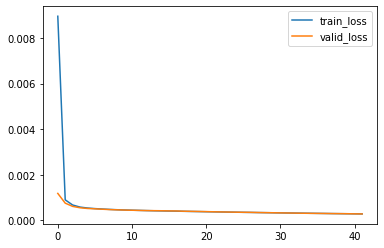

In [4]:
# train
c620_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=42,limit_y_range=True)
c620_f.train()

In [5]:
# test
x_test = c620_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c620_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
c620_f.show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.997379,3.42878e-05,0.193543
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.997721,0.00740987,0.15047
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.992835,0.00246701,0.0872139
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.997758,0.00244379,0.411833
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,0.999993,1.91304e-08,0.0279685
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,0.999993,3.52325e-09,0.027968
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [6]:
def F(case,input_wt,op):
  sp = c620_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:28,  1.42it/s]

epoch:0 train_loss:0.0045 valid_loss:0.0005


100%|██████████| 42/42 [00:28<00:00,  1.46it/s]


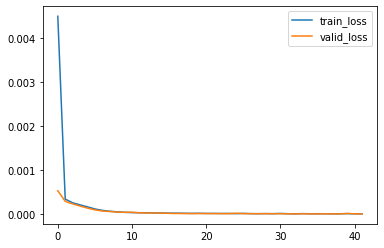

In [7]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.train()

In [8]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999981,2.86416e-11,0.000453746
Density_Vent Gas Production Rate and Composition,0.998875,2.51093e-08,0.0218667
Density_Distillate Production Rate and Composition,0.999528,4.90026e-08,0.0191816
Density_Sidedraw Production Rate and Composition,0.999877,1.40581e-10,0.00102243
Density_Bottoms Production Rate and Composition,0.999965,5.8883e-13,6.0508e-05
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.999762,0.032502,0.0958941
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.999906,0.000116715,0.0523938
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.999908,0.000157636,0.0630808
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.999821,0.000236059,0.0073495
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.9999,7.63969e-05,0.00293611


In [9]:
cond = (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] >= 69) & (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] <= 71)
sample = df[cond].sample(1)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [10]:
sample[output_wt_col]

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [11]:
sample['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']

068-107    70.000008
Name: Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%, dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'  == 70

In [12]:
!pip install optuna > log.txt

In [13]:
sample[input_wt_col]

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
068-107,0.0,0.023233,0.56132,0.512709,0.148361,0.067386,0.013974,14.842036,0.00636,0.012882,0.0,0.010175,39.232159,0.006783,0.007985,0.007985,0.945686,7.385043,16.132347,6.608338,0.011588,0.005576,0.00219,0.006505,0.911681,0.47768,2.419997,0.268579,6.181028,0.0,0.986957,0.032527,0.000929,0.021375,0.835475,0.0,0.960936,0.246275,0.105945,0.0,0.0


In [14]:
sample[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
068-107,70.000008


In [15]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [16]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl']

In [17]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端bz = sample[case_col]['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%'][0]
  輸出端bz = F(sample[case_col],sample[input_wt_col],op)['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'].values[0]
  loss = (輸入端bz - 輸出端bz)**2
  
  return loss

In [18]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-04-20 04:07:21,658] A new study created in memory with name: no-name-e1ce9757-61e7-4bec-8d2e-eb39c556ecab
[I 2021-04-20 04:07:21,721] Trial 0 finished with value: 7.352829152729186 and parameters: {'Density_Feed Properties': 0.8623280353235948, 'Density_Vent Gas Production Rate and Composition': 0.45087725954877955, 'Density_Distillate Production Rate and Composition': 0.8042998043391455, 'Density_Sidedraw Production Rate and Composition': 0.8813721181156396, 'Density_Bottoms Production Rate and Composition': 0.8721702122953473, 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 148.5839747989037, 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 12.372383586579291, 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 12.36506355193219, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 177.48272310331402, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 194

In [19]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
068-107,0.863041,0.437271,0.787094,0.8789,0.872168,103.587649,12.220845,12.945499,175.180784,193.791744


In [20]:
# 看有沒有符合業主需要的70
F(case,input_wt,op_opt)[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
068-107,70.001729


In [21]:
op_pred = G.predict(sample[case_col+input_wt_col])

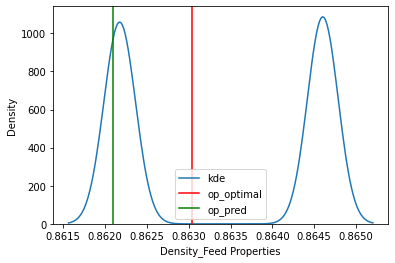

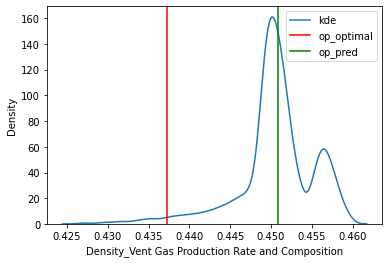

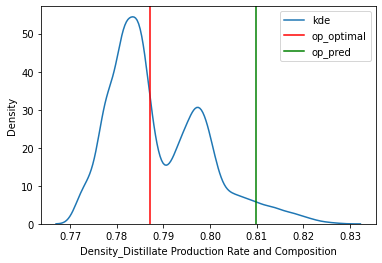

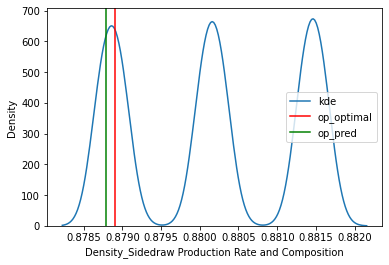

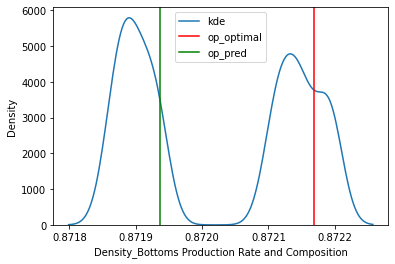

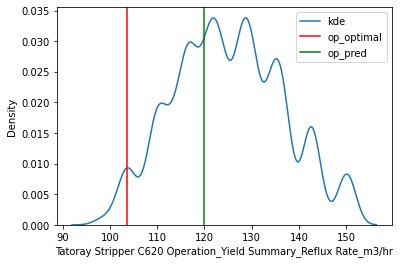

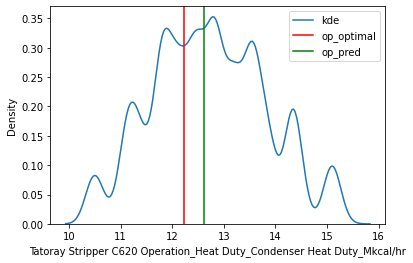

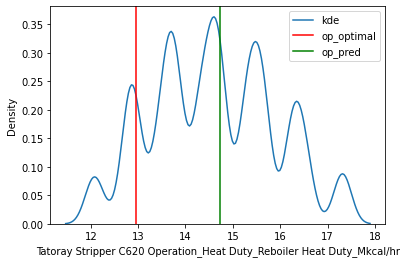

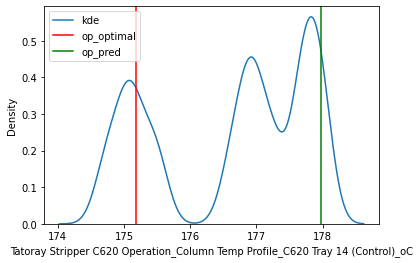

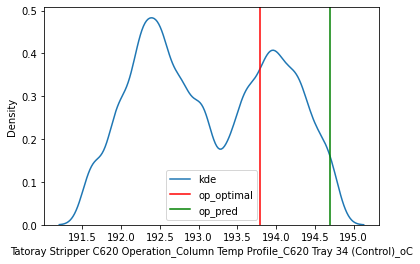

In [22]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [23]:
import joblib
G.shrink()
c620_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')
joblib.dump(c620_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl']